In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras

from glob import glob
import os
import shutil

import numpy as np
import pandas as pd
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# AIM
## To classify the images into 
### IDC+
### IDC-

# Validation Strategy:

## Train Data Size= 0.7*Total_Data
## Validation Data Size= 0.21* Total_Data
## Test Data Size= 0.09 * Total_Data

# Augmentaions Used:
## Each Image is rotated through 45 angles


In [ ]:

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")

In [ ]:
sampling_seed=47
size_4_training=10000
img_size=150
training_reshape=(-1, img_size, img_size, 3)

Image labelling

In [ ]:
import random
#make directory for labelling
os.makedirs('../working/idc2/idc-minus/')     
os.makedirs('../working/idc2/idc-plus/')  


class0 = [] # 0 = idc+
class1 = [] # 1 = idc-
imagePatches = glob('../input/breast-histopathology-images/IDC_regular_ps50_idx5/**/*.png', recursive=True)
for filename in imagePatches:
    if filename.endswith("class0.png"):
         class0.append(filename)
    else:
        class1.append(filename)

print(class0[0:10])

#sampling 10000 images from class 0 and class 1 to train the model

random.seed(sampling_seed)
class0sample=random.sample(class0,size_4_training)
class1sample=random.sample(class1,size_4_training)


def read_and_save_data(path, file_name_array):
    j=0
    for i in file_name_array:
        if i.endswith('.png'):
          
            
            #second copy method
            head, tail = os.path.split(i)
            outputname=str(path+tail)
            #outputname=str(path+str(j)+'.png')
            #print(outputname)
            shutil.copy(i, outputname)
   
            #print(status2)
            
            j=j+1
            if j==120000:
                break
            
   
class0path='../working/idc2/idc-minus/'
class1path='../working/idc2/idc-plus/'




read_and_save_data(class0path,class0sample)
read_and_save_data(class1path,class1sample)

In [ ]:

from PIL import Image
import glob


In [ ]:
import os #Operating System
import sys #System
# train_generator = train_datagen.flow(x_train, y_train, batch_size =)
# val_generator = val_datagen.flow(x_val, y_val, batch_size = 64)
# test_generator=test_datagen.flow(x_test,y_test,batch_size = 64)


#import image

In [ ]:
import cv2

def readImage(path, tag):
    j=0
    image_data = []
    for i in os.listdir(path):
        imgname=path+i
        #print(imgname)
        img = cv2.imread(imgname, cv2.IMREAD_COLOR)
        img_resized = cv2.resize(img, (img_size,img_size), interpolation=cv2.INTER_LINEAR)
        image_data.append([img_resized, tag])
        #print(img[1])
        j=j+1
        #if j==10:
        #    break
        
    return image_data

In [ ]:
import numpy as np


class0_array = readImage(class0path, 0)
class1_array = readImage(class1path, 1)
class0_array=np.array(class0_array)
class1_array=np.array(class1_array)
combined_data = np.concatenate((class0_array, class1_array))
random.seed(41)
random.shuffle(combined_data)
print(class0_array.shape)
print(combined_data.shape)

X = []
y = []

for features,label in combined_data:
    X.append(features)
    y.append(label)
#print(X.shape)
#pring(y.shape)

# reshape X data
X = np.array(X).reshape(training_reshape)
print(X.shape)

In [ ]:
X_train, X_test1, y_train, y_test1 = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.3, random_state=42)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

In [ ]:
#Callbacks
c2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
nClasses=2

# MobileNet

In [17]:
'''
#vgg16_base_model = VGG16(include_top=False, input_shape=(img_size, img_size,3), weights='imagenet')
# fix pretrained layers for deep feature extraction
#vgg16_base_model.trainable = False
from tensorflow.keras.applications import ResNet50
resnet50_base_model=ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet')
resnet50_base_model.trainable = False
# add custom top layers
x = resnet50_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(4096,activation="relu")(x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=resnet50_base_model.input, outputs=predictions)
model.summary()

#ResNet50
#base_Neural_Net= ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
# Fixed for idc+/- classes
NUM_CLASSES = 2

# Fixed for rgb color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'sigmoid'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 10
EARLY_STOP_PATIENCE = 3
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

from keras.applications import resnet
base_Resnet50=resnet.ResNet50(include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet')

for layer in base_Resnet50.layers:
    layer.trainable = False


# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))
model.summary()


model=Sequential()
model.add(base_Resnet50)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(4096,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
x = Dense(2096,activation="relu")(x)
predictions = Dense(2, activation='sigmoid')(x)
model = Model(inputs=resnet50_base_model.input, outputs=predictions)
model.summary()
'''
#base_Neural_Net= InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)
# Fixed for idc+/- classes
NUM_CLASSES = 2

# Fixed for rgb color images
CHANNELS = 3

IMAGE_RESIZE = 150
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'sigmoid'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 30
EARLY_STOP_PATIENCE = 3\
#resnet_weights_path = '../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

from tensorflow.keras.applications import InceptionV3
local_weights_file = '/kaggle/input/inceptionv3/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

#pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
     layer.trainable = False

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

from tensorflow.keras import layers  
x = layers.Flatten()(last_output)
#x = layers.Dense(1024, activation='relu')(x)
#x = layers.Dropout(0.2)(x)                  
#x = layers.Dense(2, activation='softmax')(x)  
#model = Model(pre_trained_model.input, x)
x = Dense(4096,activation="relu")(x)
x = Dropout(0.2)(x)
x = Dense(2096,activation="relu")(x)
x = Dense(2, activation='sigmoid')(x)
model = Model(pre_trained_model.input, x)
model.summary()



# confirm unfrozen layers
for layer in model.layers:
    if layer.trainable==True:
        print(layer)

last layer output shape:  (None, 7, 7, 768)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 74, 74, 32)   96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 74, 74, 32)   0           batch_normalization_94[0][0]     
________________________________________________

In [18]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image
plot_model(model, to_file='convnet.png', show_shapes=True,show_layer_names=True)
Image(filename='convnet.png') 

In [19]:
callbacks = [EarlyStopping(monitor='val_loss', patience=5, verbose=1), ModelCheckpoint('model.hdf5', save_best_only=True)]
#opt = Adam(learning_rate=0.001)
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#compiler from inceptionV3 tutorial
#model.compile(optimizer = RMSprop(lr=0.0001), loss = 'sparse_categorical_crossentropy', metrics = ['acc'])
#sparse_catagorical_crossentropy requires special shape
model.compile(optimizer = RMSprop(lr=0.0001), loss = 'categorical_crossentropy', metrics = ['acc'])

In [20]:
%time
history=model.fit(X_train, y_train,validation_data=(X_test, y_test),verbose = 1,epochs = 30,callbacks=callbacks)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.44 µs


2022-05-05 18:25:28.535082: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 945000000 exceeds 10% of free system memory.
2022-05-05 18:25:29.524604: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 945000000 exceeds 10% of free system memory.
2022-05-05 18:25:30.354272: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-05-05 18:25:34.071717: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


438/438 [==============================] - 34s 57ms/step - loss: 15.7245 - acc: 0.7670 - val_loss: 0.4092 - val_acc: 0.8544


2022-05-05 18:26:04.792843: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 616562688 exceeds 10% of free system memory.
2022-05-05 18:26:06.889151: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 616562688 exceeds 10% of free system memory.


Epoch 2/30
438/438 [==============================] - 23s 54ms/step - loss: 0.8888 - acc: 0.7926 - val_loss: 0.3633 - val_acc: 0.8522


2022-05-05 18:26:33.575441: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 616562688 exceeds 10% of free system memory.


Epoch 3/30
438/438 [==============================] - 24s 54ms/step - loss: 0.5483 - acc: 0.8257 - val_loss: 0.6606 - val_acc: 0.8606
Epoch 4/30
438/438 [==============================] - 23s 53ms/step - loss: 0.4774 - acc: 0.8386 - val_loss: 0.3486 - val_acc: 0.8739
Epoch 5/30
438/438 [==============================] - 23s 53ms/step - loss: 0.4740 - acc: 0.8376 - val_loss: 0.3646 - val_acc: 0.8628
Epoch 6/30
438/438 [==============================] - 23s 53ms/step - loss: 0.4155 - acc: 0.8484 - val_loss: 0.3795 - val_acc: 0.8622
Epoch 7/30
438/438 [==============================] - 24s 54ms/step - loss: 0.4039 - acc: 0.8539 - val_loss: 0.3400 - val_acc: 0.8550
Epoch 8/30
438/438 [==============================] - 23s 53ms/step - loss: 0.4063 - acc: 0.8514 - val_loss: 0.4000 - val_acc: 0.8639
Epoch 9/30
438/438 [==============================] - 24s 54ms/step - loss: 0.3983 - acc: 0.8551 - val_loss: 0.4025 - val_acc: 0.8361
Epoch 10/30
438/438 [==============================] - 23s 53m

In [21]:
def f1_score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [22]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        f1_score,
]

KeyError: 'accuracy'

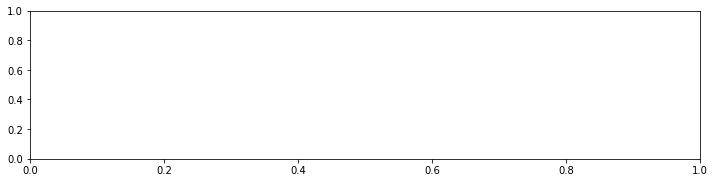

In [23]:
#plot the accuracy graph
plt.figure(figsize = (12,6))
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label="train_acc")
plt.plot(history.history['val_accuracy'], label = "test_acc")
plt.legend()
plt.subplot(2,1,2)
plt.plot(history.history['loss'], label = "train_loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()

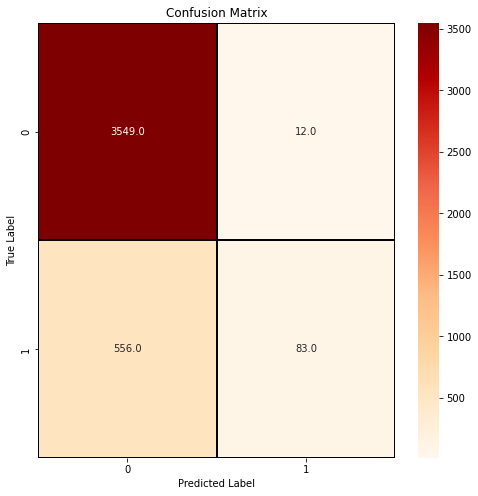

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_val,axis = 1) 

confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="OrRd",linecolor="black", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [25]:
from sklearn.metrics import classification_report

print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93      3561
           1       0.87      0.13      0.23       639

    accuracy                           0.86      4200
   macro avg       0.87      0.56      0.58      4200
weighted avg       0.87      0.86      0.82      4200



In [26]:
%cd /kaggle/working
from IPython.display import FileLink
FileLink('model.hdf5')

/kaggle/working


/kaggle/working/model.hdf5

In [27]:
from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, accuracy_score, confusion_matrix
def get_accuracy_metrics(model, X_train, y_train, X_val, y_val, X_test, y_test):
    y_train=np.argmax(y_train, axis=1)
    y_test=np.argmax(y_test, axis=1)
    y_val=np.argmax(y_val, axis=1)
    y_train_pred=np.argmax(model.predict(X_train),axis=1)
    y_test_pred=np.argmax(model.predict(X_test),axis=1)
    y_val_pred=np.argmax(model.predict(X_val),axis=1)
    print("Train accuracy Score------------>")
    print ("{0:.3f}".format(accuracy_score(y_train, y_train_pred)*100), "%")
    
    print("Val accuracy Score--------->")
    
    print("{0:.3f}".format(accuracy_score(y_val, y_val_pred)*100), "%")
    
  
    print("Test accuracy Score--------->")
    print("{0:.3f}".format(accuracy_score(y_test, y_test_pred)*100), "%")
    
    print("F1 Score--------------->")
    print("{0:.3f}".format(f1_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Cohen Kappa Score------------->")
    print("{0:.3f}".format(cohen_kappa_score(y_test, y_test_pred)*100), "%")
    
    print("Recall-------------->")
    print("{0:.3f}".format(recall_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    print("Precision-------------->")
    print("{0:.3f}".format(precision_score(y_test, y_test_pred, average = 'weighted')*100), "%")
    
    cf_matrix_test = confusion_matrix(y_test, y_test_pred)
    cf_matrix_val = confusion_matrix(y_val, y_val_pred)
    
    plt.figure(figsize = (12, 6))
    plt.subplot(121)
    sns.heatmap(cf_matrix_val, annot=True, cmap='Blues')
    plt.title("Val Confusion matrix")
    
    plt.subplot(122)
    sns.heatmap(cf_matrix_test, annot=True, cmap='Blues')
    plt.title("Test Confusion matrix")
    
    plt.show()

Train accuracy Score------------>
86.871 %
Val accuracy Score--------->
86.476 %
Test accuracy Score--------->
87.333 %
F1 Score--------------->
83.055 %
Cohen Kappa Score------------->
19.489 %
Recall-------------->
87.333 %
Precision-------------->
87.273 %


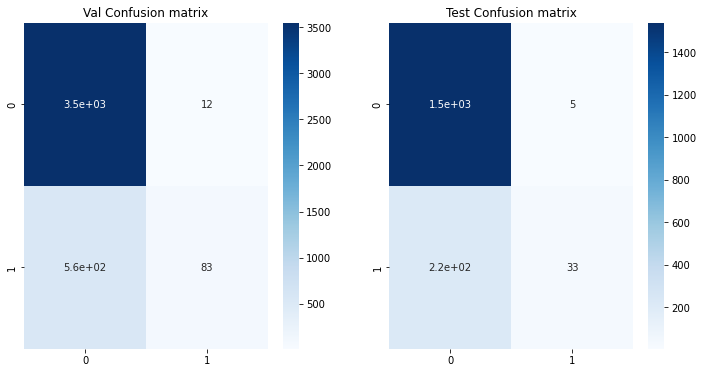

In [28]:
get_accuracy_metrics(model,  X_train, y_train, X_val, y_val, X_test, y_test)